# Maximum Velocity Quantum Circuits

In [1]:
%matplotlib inline

#Load necessary packages
import math
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import eigh, expm
import matplotlib.pyplot as plt

In [2]:
#Load plotting parameters
from PlotParams import *

In the following, we provide code for the calculation of out-of-time-order correlators in general unitary circuits, which we then compare with the analytic predictions for different classes of maximum velocity circuits.

The notation in the code is consistent with the one from the paper, satisfying


![Definitions](definition_UUdag.png)

In the following, we first define the different unitary gates studied in the paper: dual-unitary gates, kicked Ising models, and kicked XY models.

In [3]:
#Define Pauli basis
Id = np.array([[1,0],[0,1]])
X = np.array([[0,1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1,0], [0, -1]])

IdId = np.einsum("ac,bd->abcd", Id, Id
)

In [4]:
"""
a   b
|   |
-----
| U |
-----
|   |
c   d
"""

#Define random dual-unitary gate given fixed J
def dual_unitary_gate(J):
    #Define Pauli basis
    Id = np.array([[1,0],[0,1]])
    X = np.array([[0,1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1,0], [0, -1]])
    sigma = [X,Y,Z]

    #Entangling two-qubit gate
    M = 0.25*np.pi*(np.einsum('ac,bd->abcd', X, X)+np.einsum('ac,bd->abcd', Y, Y))-J*np.einsum('ac,bd->abcd', Z, Z)
    V = (expm(-1j*M.reshape(4,4))).reshape([2,2,2,2])
    
    #Add random SU(2) element to each leg
    n_u_p = np.random.rand(3)
    n_u_p = n_u_p/(np.linalg.norm(n_u_p))
    theta_u_p = np.random.rand()
    
    n_u_m = np.random.rand(3)
    n_u_m = n_u_m/(np.linalg.norm(n_u_m))
    theta_u_m = np.random.rand()
    
    n_v_p = np.random.rand(3)
    n_v_p = n_v_p/(np.linalg.norm(n_v_p))
    theta_v_p = np.random.rand()
    
    
    n_v_m = np.random.rand(3)
    n_v_m = n_v_m/(np.linalg.norm(n_v_m))
    theta_v_m = np.random.rand()
    
    u_plus = np.cos(theta_u_p) * Id + 1j*np.sin(theta_u_p) * np.sum([n_u_p[i]*sigma[i] for i in range(3)],axis=0)
    u_min = np.cos(theta_u_m) * Id + 1j*np.sin(theta_u_m) * np.sum([n_u_m[i]*sigma[i] for i in range(3)],axis=0)
    v_plus = np.cos(theta_v_p) * Id + 1j*np.sin(theta_v_p) * np.sum([n_v_p[i]*sigma[i] for i in range(3)],axis=0)
    v_min = np.cos(theta_v_m) * Id + 1j*np.sin(theta_v_m) * np.sum([n_v_m[i]*sigma[i] for i in range(3)],axis=0)
    
    phi = np.pi*np.random.rand()
    U = np.exp(1j*phi) * np.einsum( 'ac,bd,cdef,eg,fh-> abgh' ,u_plus, u_min, V, v_plus, v_min)
    return(U)

#Define gate for Kicked Ising Model at the self-dual point
def KIM_gate(h_1, h_2):
    #Fix self-dual point
    J = np.pi/4.
    b = np.pi/4.
    X = np.array([[0,1], [1, 0]])
    Z = np.array([[1,0], [0, -1]])
    
    #Kick operator
    X_exp = np.cos(b) * np.identity(2) - 1j * np.sin(b) * X
    
    #Hamiltonian evolution
    Z_1_exp = np.cos(0.5*h_1) * np.identity(2) - 1j * np.sin(0.5*h_1) * Z
    Z_2_exp = np.cos(0.5*h_2) * np.identity(2) - 1j * np.sin(0.5*h_2) * Z
    ZZ = np.einsum("ac,bd->abcd", Z, Z)
    IdId = np.einsum("ac,bd->abcd", np.identity(2), np.identity(2))
    ZZ_exp = np.cos(J) * IdId - 1j * np.sin(J) * ZZ
    
    #Combine
    K_1 = np.einsum('ab,bc,cd->ad',Z_1_exp,X_exp,Z_1_exp)
    K_2 = np.einsum('ab,bc,cd->ad',Z_2_exp,X_exp,Z_2_exp)
    return np.einsum("abcd,ce,df,efjk -> abjk", ZZ_exp, K_1, K_2, ZZ_exp)

#Define general two-qubit entangling gate
#V = exp(-i(J_x X*X + J_Y Y*Y + J_z Z*Z))
def V_gate(J_x, J_y, J_z):
    Id = np.array([[1,0],[0,1]])
    X = np.array([[0,1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1,0], [0, -1]])
    IdId = np.einsum("ac,bd->abcd", np.identity(2), np.identity(2))
    XX = np.einsum("ac,bd->abcd", X, X)
    XX_exp = np.cos(J_x) * IdId - 1j * np.sin(J_x) * XX
    YY = np.einsum("ac,bd->abcd", Y, Y)
    YY_exp = np.cos(J_y) * IdId - 1j * np.sin(J_y) * YY
    ZZ = np.einsum("ac,bd->abcd", Z, Z)
    ZZ_exp = np.cos(J_z) * IdId - 1j * np.sin(J_z) * ZZ
    
    return np.einsum('abcd,cdef,efgh -> abgh', XX_exp, YY_exp, ZZ_exp)

#Define kicked XY gate
def XY_gate(J):
    Id = np.array([[1,0],[0,1]])
    X = np.array([[0,1], [1, 0]])
    v_ = np.cos(0.25*np.pi)*Id+1j*np.sin(0.25*np.pi)*X
    return np.einsum('ebcf, ae, fd-> abcd', V_gate(0.*np.pi, -0.25*np.pi, -J), Id, v_) 


In [5]:
#Define contraction of tensors and/or vectors

def inner_product(vec_1, vec_2):
    #Calculate inner product of two vectors
    assert(vec_1.shape == vec_2.shape)
    num_indices = len(vec_1.shape)
    return np.tensordot(vec_1.conj(), vec_2, axes=num_indices)

def mult_tens_vec(tens,vec):
    #Apply tensor to vector
    assert(vec.shape + vec.shape == tens.shape)
    n_ind = len(vec.shape)
    vec_cont = np.einsum(tens, list(range(1,2*n_ind+1)), vec, list(range(n_ind+1,2*n_ind+1)))
    return vec_cont
    
def mult_vec_vec(vec_1,vec_2):
    #Contract two vectors
    assert(vec_1.shape == vec_2.shape)
    n_ind = len(vec_1.shape)
    ind = list(range(1,n_ind+1))
    return np.einsum(vec_1, ind, vec_2, ind)

#Cast tensors to matrices
def tensor_to_matrix(tensor):
    #Given tensor T_abcd...efgh... returns matrix M_{abcd..., efgh...}
    num_row_indices = len(tensor.shape) // 2
    q = tensor.shape[0]
    return tensor.reshape(2 * [q ** num_row_indices])

#Cast tensors to vectors
def tensor_to_vector(tensor):
    #Given tensor T_abcd... returns vector V_{abcd...}
    num_row_indices = len(tensor.shape) 
    q = tensor.shape[0]
    return tensor.reshape([q ** num_row_indices])


The diagram of the OTOC depends on the parity of the distance from the lightcone $(t-x)$. 

For $t-x$ is even, the OTOC is given by


<img src="OTOC_even.png" alt="Drawing" style="width: 600px;"/>


\begin{equation}
n_+ = \frac{1}{2}\left[t+(x-y)\right], \qquad n_- = \frac{1}{2}\left[(t+2)-(x-y)\right].
\end{equation}

For $t-x$ odd, the OTOC is given by

<img src="OTOC_odd.png" alt="Drawing" style="width: 600px;"/>


\begin{equation}
n_+ = \frac{1}{2}\left[(t+1)+(x-y)\right], \qquad n_- = \frac{1}{2}\left[(t+1) - (x-y)\right].
\end{equation}

In the following, code is provided to construct the column transfer matrix and the left and right boundaries, from which the evolution of the OTOC for fixed $n_-$ can be calculated.

In [6]:
#Define transfer matrix, left and right boundaries

"""
Transfer matrix defined as going from left to right
T_{ab...cd ef...gh}     R_{ab...cd}        L_{ab...cd}

a-|---|-e                a-|---|            |---|-a   
b-|   |-f                b-|   |            |   |-b
: |   | :                : |   |            |   | :
: | T | :                : | R |            | L | :
c-|   |-g                c-|   |            |   |-c
d-|---|-h                d-|---|            |---|-d
"""

def construct_T(U, n_t):
    #Construct T for a fixed number of layers n_t = n_{-}
    #Returns (4 n_t * 4 n_t tensor with each leg having dimension q)
    
    q = U.shape[0]
    
    #Builds up the transfer matrix from the bottom
    #First layer of U's
    T = np.einsum('astb-> sabt',U)
    for i in range(n_t-1):
        T = np.einsum('asub,u...t -> sa...bt',U,T)
    #First layer of U^{\dag}'s'
    for i in range(n_t):
        T = np.einsum('ausb,u...t -> sa...bt',np.conj(U),T)
    #Second layer of U's
    for i in range(n_t):
        T = np.einsum('asub,u...t -> sa...bt',U,T)
    #Second layer of U^{\dag}'s
    for i in range(n_t):
        T = np.einsum('ausb,u...t -> sa...bt',np.conj(U),T)
        
    #Final contraction along vertical axis
    T = np.einsum('s...s -> ...', T) 
    #Reorder right-hand side indices
    ind = list(range(1,4*n_t+1)) + list(range(8*n_t,4*n_t,-1))
    T = np.einsum(T,ind)
    return T / q

def construct_L(op_L, n_t):
    #Construct left boundary for a fixed number of layers n_t
    #Returns 4 n_t * 1 tensor with each leg having dimension q
    
    q = op_L.shape[0]
    
    L = np.einsum('ab -> ab', op_L)    #Start with operator, keeping indices explicit
    for i in range(n_t-1):
        L = np.einsum('ab, ... -> a...b', Id, L)    #Pad with identities   

    #Combine two halves into full tensor
    ind_1 = list(range(1,2*n_t+1))
    ind_2 = list(range(2*n_t+1,4*n_t+1))
    L = np.einsum(L, ind_1, L, ind_2)
    return L / np.sqrt(q**n_t)

def construct_R_even(op_R, n_t):
    #Construct right boundary for a fixed number of layers n_t and even parity
    #Returns 4 n_t vector
    
    q = op_R.shape[0]
    
    R = np.einsum('ab -> ab', op_R)    #Start with operator, keeping indices explicit
    for i in range(n_t-1):
        R = np.einsum('ab, ... -> a...b', Id, R)    #Pad with identities
    for i in range(n_t-1):
        R = np.einsum('ba, ... -> a...b', Id, R)    #Pad with identities
    R = np.einsum('ba, ... -> a...b', op_R, R)    #Add operator
    return R / np.sqrt(q**n_t)

def construct_R_odd(op_R, U, n_t):
    #Construct right boundary for a fixed number of layers n_t and odd parity
    #Express as transfer matrix with additional operators
    
    q = U.shape[0]
    
    #Builds up the transfer matrix from the bottom
    #First layer of U's building on operator 
    T_r = np.einsum('ut,asub-> sabt', op_R, U)              #Used to be tu,asub - check!
    for i in range(n_t-1):
        T_r = np.einsum('asub,u...t -> sa...bt',U,T_r)
    #First layer of U^{\dag}'s'
    for i in range(n_t):
        T_r = np.einsum('ausb,u...t -> sa...bt',np.conj(U),T_r)
    #Introduce operator
    T_r = np.einsum('su,u...t -> s...t',op_R,T_r)
    #Second layer of U's
    for i in range(n_t):
        T_r = np.einsum('asub,u...t -> sa...bt',U,T_r)
    #Second layer of U^{\dag}'s
    for i in range(n_t):
        T_r = np.einsum('ausb,u...t -> sa...bt',np.conj(U),T_r)
        
    #Final contraction along vertical axis
    T_r = np.einsum('s...s -> ...', T_r) 
    #Reorder right-hand side indices
    ind = list(range(1,4*n_t+1)) + list(range(8*n_t,4*n_t,-1))
    
    T_r = np.einsum(T_r,ind)
    R =  mult_tens_vec(T_r,construct_R_even(Id,n_t)) / q
    return R

In [7]:
#Perform evolution through tensor contraction

#(x-t) even
def evol_even(U, op_L, op_R, n_l, n_t):
    t_range = np.arange(n_t)
    OTOC_range = np.zeros(n_t,dtype=complex)
    
    q = U.shape[0]
    T_tens = construct_T(U, n_l)
    R_vec = construct_R_even(op_R, n_l)
    L_vec = construct_L(op_L, n_l)
    
    t_vec = R_vec
    for t_i in t_range:
        OTOC_range[t_i] = mult_vec_vec(L_vec, t_vec)
        #print(OTOC_range[t_i])
        new_vec  = mult_tens_vec(T_tens, t_vec)
        t_vec = new_vec
    return [t_range,OTOC_range]


#(x-t) odd
def evol_odd(U, op_L, op_R, n_l, n_t):
    t_range = np.arange(n_t)
    OTOC_range = np.zeros(n_t,dtype=complex)
    
    q = U.shape[0]
    T_tens = construct_T(U, n_l)
    R_vec = construct_R_odd(op_R, U, n_l)
    L_vec = construct_L(op_L, n_l)
    
    t_vec = R_vec
    OTOC_range[0] = 0.
    for t_i in t_range:
        OTOC_range[t_i] = mult_vec_vec(L_vec, t_vec)
        #print(OTOC_range[t_i])
        new_vec  = mult_tens_vec(T_tens, t_vec)
        t_vec = new_vec
    return [t_range,OTOC_range]


All long-time values follow from the quantum channels, which are defined as

<img src="quantumchannels.png" alt="Drawing" style="width: 500px;"/>


In [8]:
#Define quantum channels for steady-state OTOC values
def M_channel_plus(op, U):
    q = U.shape[0]
    return np.einsum('eacf, cd, ebdf  -> ab', U, op, np.conj(U)) / q

def M_channel_min(op, U):
    q = U.shape[0]
    return np.einsum('ecaf, cd, edbf  -> ab', np.conj(U), op, U) / q

def M_n(op, U, n):
    q = U.shape[0]
    M_init = op
    for i in range(n):
        M_init = M_channel_plus(M_init, U)
    for i in range(n):
        M_init = M_channel_min(M_init, U)
    return (np.einsum('ab,ba', M_init, op) / q)

def OTOC_ss(op, U, n):
    q = U.shape[0]
    return (q**2 * M_n(op, U, n) - M_n(op, U, n-1)).real/(q**2-1.)
    

# Maximally chaotic dual-unitary circuits

In [9]:
#Explicitly check unitarity and dual-unitarity
U = dual_unitary_gate(J = 0.1)
q = U.shape[0]

#Check unitarity of U
print("Check unitarity: U * U^{\dag} - 1 = ", np.linalg.norm(np.einsum('abcd,efcd -> abef', U, np.conj(U))-IdId))
print("Check unitarity: U^{\dag} * U - 1 = ", np.linalg.norm(np.einsum('cdab,cdef -> abef', np.conj(U), U)-IdId))

#Check dual unitarity of U
print("Check dual unitarity: tilde{U} * tilde{U}^{\dag} - 1 = ",
      np.linalg.norm(np.einsum('fbea,fdec->abcd',np.conj(U),U)-IdId))
print("Check dual unitarity: tilde{U}^{\dag} * tilde{U} - 1 = ",
      np.linalg.norm(np.einsum('bfae,dfce->abcd',np.conj(U),U)-IdId))

Check unitarity: U * U^{\dag} - 1 =  4.918300529807393e-16
Check unitarity: U^{\dag} * U - 1 =  4.474981391008672e-16
Check dual unitarity: tilde{U} * tilde{U}^{\dag} - 1 =  7.756677862503847e-16
Check dual unitarity: tilde{U}^{\dag} * tilde{U} - 1 =  7.635306111519146e-16


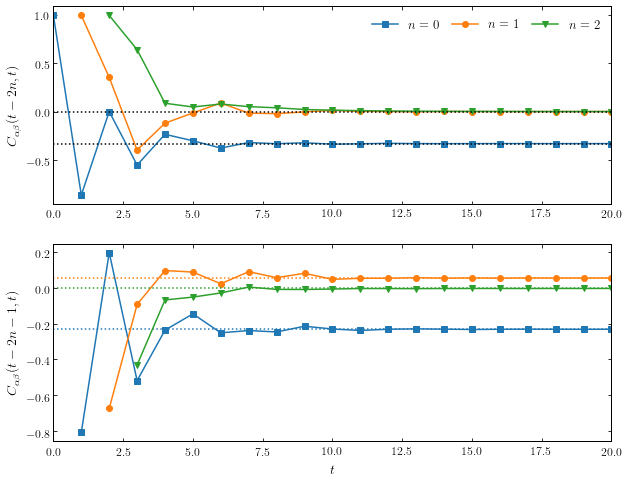

In [10]:
#Calculate OTOC given sigma_alpha and sigma_beta
a_x, a_y, a_z = 1., 0., 0.
b_x, b_y, b_z = 1., 0., 0.

#Construct sigma_alpha and sigma_beta
op_a, op_b = a_x*X+a_y*Y+a_z*Z, b_x*X+b_y*Y+b_z*Z

#Number of time steps
n_t = 25

#Create figure
fix,[ax1,ax2] = plt.subplots(2,1,figsize=[10,8])

#(t-x) even
[t_range, OTOC] = evol_even(U, op_a, op_b, 1, n_t)
ax1.plot(t_range, OTOC.real,'C0s-',label=r'$n = 0$')

[t_range, OTOC] = evol_even(U, op_a, op_b, 2, n_t)
ax1.plot(1.+t_range, OTOC.real,'C1o-',label=r'$n = 1$')

[t_range, OTOC] = evol_even(U, op_a, op_b, 3, n_t)
ax1.plot(2.+t_range, OTOC.real,'C2v-',label=r'$n = 2$')

#(t-x) odd
[t_range, OTOC] = evol_odd(U, op_a, op_b, 1, n_t)
ax2.plot(1.+t_range, OTOC.real,'C0s-',label=r'$n = 0$')
ax2.plot(t_range, [OTOC_ss(op_b, U, 1)]*len(t_range),'C0:' )

[t_range, OTOC] = evol_odd(U, op_a, op_b, 2, n_t)
ax2.plot(2.+t_range, OTOC.real,'C1o-',label=r'$n = 1$')
ax2.plot(t_range, [OTOC_ss(op_b, U, 2)]*len(t_range),'C1:' )

[t_range, OTOC] = evol_odd(U, op_a, op_b, 3, n_t)
ax2.plot(3.+t_range, OTOC.real,'C2v-',label=r'$n = 2$')
ax2.plot(t_range, [OTOC_ss(op_b, U, 3)]*len(t_range),'C2:' )

ax1.plot(t_range, [-1./3.]*len(t_range),'k:')
ax1.plot(t_range, [0.]*len(t_range),'k:')


ax1.set_xlim([0.,20.])
ax2.set_xlim([0.,20.])
ax1.set_ylabel(r'$C_{\alpha \beta}(t-2n,t)$')
ax2.set_ylabel(r'$C_{\alpha \beta}(t-2n-1,t)$')
ax2.set_xlabel(r'$t$')
ax1.legend(ncol=3,columnspacing=1.)

plt.show()

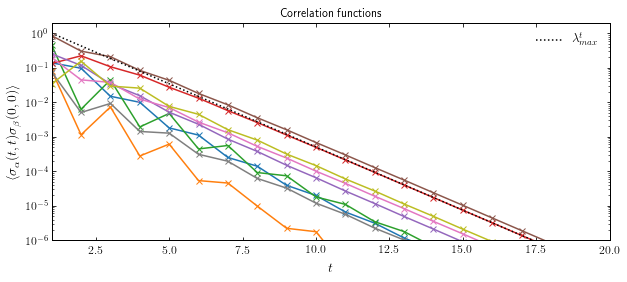

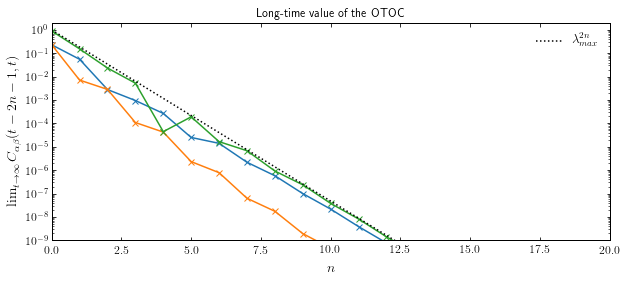

In [11]:
#Get maximal non-unit eigenvalue lam_max of M_plus
M_mat = tensor_to_matrix(np.einsum('eacf,ebdf', U, np.conj(U)))/q
[E,_] = np.linalg.eig(M_mat)
lam_max = (np.sort(np.abs(E))[-2])


#Correlation functions on the light cone
fig, ax = plt.subplots(figsize=[10,4])

#Number of time steps
n_t = 25

q = U.shape[0]
for op_a in [X,Y,Z]:
    for op_b in [X,Y,Z]:
        op_t = op_b
        corr_range = np.zeros(n_t,dtype=complex)
        for n in range(n_t):
            corr_range[n] = np.einsum('ab,ba', op_a, op_t) / q
            op_t = M_channel_plus(op_t,U)
        ax.semilogy(np.arange(1,n_t),np.abs(corr_range[1:]),'x-')
        
ax.semilogy(np.arange(1,n_t), lam_max**np.arange(n_t-1),'k:',label=r'$\lambda_{max}^{t}$')
ax.set_title(r'Correlation functions')        
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\langle \sigma_{\alpha}(t,t) \sigma_{\beta}(0,0) \rangle$')
ax.set_xlim([1.,20.])
ax.set_ylim([1e-6,2.])
ax.legend()
plt.show()
        
    
#Long-time values of the OTOC inside the light cone
fig, ax = plt.subplots(figsize=[10,4])

#Number of time steps
n_t = 25

for op_b in [X,Y,Z]:
    OTOC = np.array([OTOC_ss(op_b, U, i) for i in range(1,n_t)])
    ax.semilogy(np.arange(n_t-1),np.abs(OTOC.real),'x-')
ax.semilogy(np.arange(n_t-1), lam_max**(2.*np.arange(n_t-1)),'k:',label=r'$\lambda_{max}^{2n}$')
ax.set_title('Long-time value of the OTOC')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\lim_{t\to\infty} C_{\alpha \beta}(t-2n-1,t)$')
ax.set_xlim([0.,20.])
ax.set_ylim([1e-9,2.])
ax.legend()
plt.show()


## Kicked Ising Model at the self-dual point

In [12]:
#Parametrize KIM
h_1, h_2 = 0.6, 0.4

#Explicitly check unitarity and dual-unitarity
U = KIM_gate(h_1 = h_1, h_2 = h_2)

#Construct identity as tensor
IdId = np.einsum("ac,bd->abcd", np.identity(2), np.identity(2))
#Check unitarity of U
print("Check unitarity: U * U^{\dag} - 1 = ", np.linalg.norm(np.einsum('abcd,efcd -> abef', U, np.conj(U))-IdId))
print("Check unitarity: U^{\dag} * U - 1 = ", np.linalg.norm(np.einsum('cdab,cdef -> abef', np.conj(U), U)-IdId))

#Check dual unitarity of U
print("Check dual unitarity: tilde{U} * tilde{U}^{\dag} - 1 = ",
      np.linalg.norm(np.einsum('fbea,fdec->abcd',np.conj(U),U)-IdId))
print("Check dual unitarity: tilde{U}^{\dag} * tilde{U} - 1 = ",
      np.linalg.norm(np.einsum('bfae,dfce->abcd',np.conj(U),U)-IdId))

Check unitarity: U * U^{\dag} - 1 =  2.823712090451708e-16
Check unitarity: U^{\dag} * U - 1 =  1.7880278822442372e-16
Check dual unitarity: tilde{U} * tilde{U}^{\dag} - 1 =  9.78753060959817e-16
Check dual unitarity: tilde{U}^{\dag} * tilde{U} - 1 =  9.922375660953152e-16


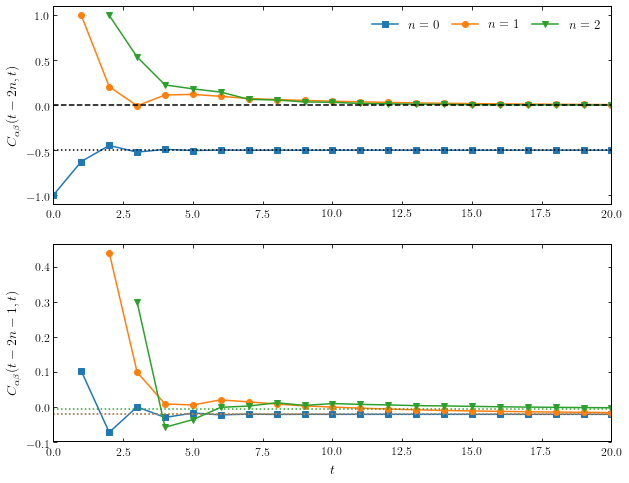

In [13]:
#Calculate OTOC given sigma_alpha and sigma_beta
a_x, a_y, a_z = np.sqrt(1./2.), 0., np.sqrt(1./2.)
b_x, b_y, b_z = 0.,1., 0.


#Construct sigma_alpha and sigma_beta
op_a, op_b = a_x*X+a_y*Y+a_z*Z, b_x*X+b_y*Y+b_z*Z


#Analytic expressions for long-time value of OTOC
def OTOC_ss_KIM(n):
      if(n==0):
        return (1.+a_z**2)*(b_x*np.cos(h_1)-b_y*np.sin(h_1))**2-a_z**2
      else:
        return ((b_x*np.cos(h_1)-b_y*np.sin(h_1))**2 * 
                 (np.cos(h_1+h_2)**2-a_z**2*np.sin(h_1+h_2)**2) * np.cos(h_1+h_2)**(2.*(n-1)) )

#Number of time steps
n_t = 50

#Create figure
fix,[ax1,ax2] = plt.subplots(2,1,figsize=[10,8])

#(t-x) even
[t_range, OTOC] = evol_even(U, op_a, op_b, 1, n_t)
ax1.plot(t_range, OTOC.real,'C0s-',label=r'$n = 0$')

[t_range, OTOC] = evol_even(U, op_a, op_b, 2, n_t)
ax1.plot(1.+t_range, OTOC.real,'C1o-',label=r'$n = 1$')

[t_range, OTOC] = evol_even(U, op_a, op_b, 3, n_t)
ax1.plot(2.+t_range, OTOC.real,'C2v-',label=r'$n = 2$')

#(t-x) odd
[t_range, OTOC] = evol_odd(U, op_a, op_b, 1, n_t)
ax2.plot(1.+t_range, OTOC.real,'C0s-',label=r'$n = 0$')
ax2.plot(t_range, [OTOC_ss_KIM(0)]*len(t_range),'C0:' )

[t_range, OTOC] = evol_odd(U, op_a, op_b, 2, n_t)
ax2.plot(2.+t_range, OTOC.real,'C1o-',label=r'$n = 1$')
ax2.plot(t_range, [OTOC_ss_KIM(1)]*len(t_range),'C1:' )

[t_range, OTOC] = evol_odd(U, op_a, op_b, 3, n_t)
ax2.plot(3.+t_range, OTOC.real,'C2v-',label=r'$n = 2$')
ax2.plot(t_range, [OTOC_ss_KIM(2)]*len(t_range),'C2:' )

ax1.plot([3.*b_z**2*a_z**2-a_z**2-b_z**2]*n_t,'k:')
ax1.plot([0.]*n_t,'k--')


ax1.set_xlim([0.,20.])
ax2.set_xlim([0.,20.])
ax1.set_ylabel(r'$C_{\alpha \beta}(t-2n,t)$')
ax2.set_ylabel(r'$C_{\alpha \beta}(t-2n-1,t)$')
ax2.set_xlabel(r'$t$')
ax1.legend(ncol=3,columnspacing=1.)

plt.show()


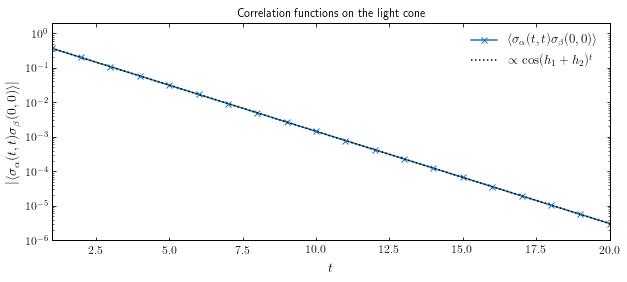

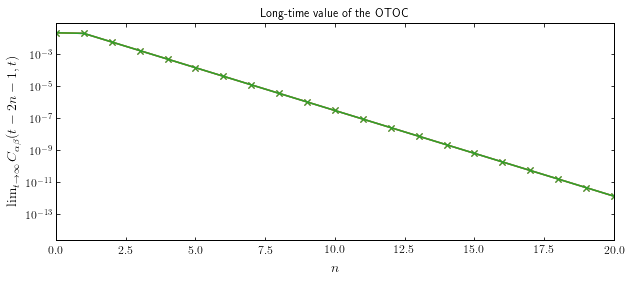

In [14]:
#Correlation functions on the light cone
fig, ax = plt.subplots(figsize=[10,4])

#Number of time steps
n_t = 25

q = U.shape[0]
op_t = op_b
corr_range = np.zeros(n_t,dtype=complex)
for n in range(n_t):
    corr_range[n] = np.einsum('ab,ba', op_a, op_t) / q
    op_t = M_channel_plus(op_t,U)
ax.semilogy(np.arange(1,n_t),np.abs(corr_range[1:]),'x-',label=r'$\langle \sigma_{\alpha}(t,t) \sigma_{\beta}(0,0) \rangle$')
ax.semilogy(np.arange(1,n_t), 
            np.abs((b_x*np.cos(h_1)-b_y*np.sin(h_1))*(a_x*np.cos(h_2)-a_y*np.sin(h_2))*np.cos(h_1+h_2)**np.arange(n_t-1)),'k:',label=r'$\propto \cos(h_1+h_2)^{t}$')
ax.set_title(r'Correlation functions on the light cone')        
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$|\langle \sigma_{\alpha}(t,t) \sigma_{\beta}(0,0) \rangle|$')
ax.set_xlim([1.,20.])
ax.set_ylim([1e-6, 2.])
ax.legend()
plt.show()
        
fig, ax = plt.subplots(figsize=[10,4])

#Number of time steps
n_t = 25

for op_b in [X,Y,Z]:
    OTOC = np.array([OTOC_ss_KIM(i) for i in range(n_t)])
    ax.semilogy(np.arange(n_t),np.abs(OTOC.real),'x-')
ax.set_title('Long-time value of the OTOC')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\lim_{t\to\infty} C_{\alpha \beta}(t-2n-1,t)$')
ax.set_xlim([0.,20.])
plt.show()


## Kicked Ising Model at the integrable and self-dual point

In [15]:
#KIM gate with h_1=h_2=0
U = KIM_gate(h_1 = 0., h_2 = 0.)

#Check identities
print("Numerical check of presented identities (should all be zero)")
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd', U, np.conj(U), Id, Id)-np.einsum('ac,bd->abcd', Id, Id)))
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd', U, np.conj(U), Id, X)-np.einsum('ac,bd->abcd', X, Id)))
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd', U, np.conj(U), Id, Y)-np.einsum('ac,bd->abcd', Y, X)))
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd', U, np.conj(U), Id, Z)-np.einsum('ac,bd->abcd', Z, X)))

print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd', U, np.conj(U), X, Id)-np.einsum('ac,bd->abcd', Id, X)))
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd', U, np.conj(U), X, X)-np.einsum('ac,bd->abcd', X, X)))
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd', U, np.conj(U), X, Y)-np.einsum('ac,bd->abcd', Y, Id)))
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd', U, np.conj(U), X, Z)-np.einsum('ac,bd->abcd', Z, Id)))


Numerical check of presented identities (should all be zero)
0.0
7.406111315403549e-16
5.266250202865052e-16
5.266250202865052e-16
7.406111315403549e-16
0.0
5.266250202865052e-16
5.266250202865052e-16


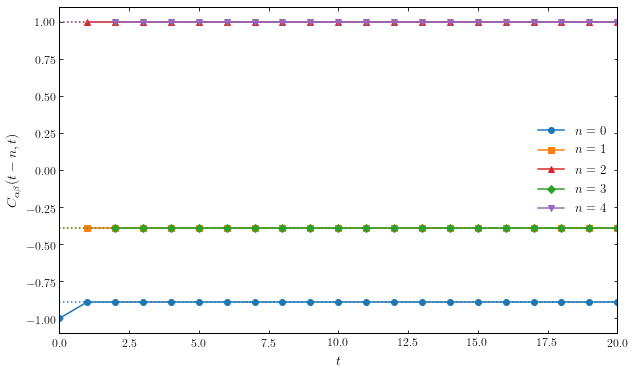

In [16]:
#Calculate OTOC given sigma_alpha and sigma_beta
a_x, a_y, a_z = np.sqrt(1./6.), np.sqrt(1./2.), np.sqrt(1./3.)
b_x, b_y, b_z =  np.sqrt(1./6.), -np.sqrt(1./2.), np.sqrt(1./3.)

#Construct sigma_alpha and sigma_beta
op_a, op_b = a_x*X+a_y*Y+a_z*Z, b_x*X+b_y*Y+b_z*Z

#Number of steps
n_t = 30

#Create figure
fix, ax = plt.subplots(figsize=[10,6])

#C(t,t)
[t_range, OTOC] = evol_even(U, op_a, op_b, 1, n_t)
ax.plot(t_range, OTOC.real,'C0o-',label=r'$n=0$')
ax.plot(t_range, [2.*((a_y*b_y+a_z*b_z)**2+a_x**2*b_x**2)-1.]*len(t_range),'C0:')

#C(t-1,t)
[t_range, OTOC] = evol_odd(U, op_a, op_b, 1, n_t)
ax.plot(t_range+1., OTOC.real,'C1s-',label=r'$n=1$')
ax.plot(t_range, [(a_x**2+(1.-a_x**2)*(2.*b_x**2-1.))]*len(t_range),'C1:')

#C(t-2,t)
[t_range, OTOC] = evol_even(U, op_a, op_b, 2, n_t)
ax.plot(t_range+1., OTOC.real,'C3^-',label=r'$n=2$')
ax.plot(t_range, [1.]*len(t_range),'C3:')

#C(t-3,t)
[t_range, OTOC] = evol_odd(U, op_a, op_b, 2, n_t)
ax.plot(t_range+2., OTOC.real,'C2D-',label=r'$n=3$')
ax.plot(t_range, [(a_x**2+(1.-a_x**2)*(2.*b_x**2-1.))]*len(t_range),'C2:')

#C(t-4,t)
[t_range, OTOC] = evol_even(U, op_a, op_b, 3, n_t)
ax.plot(t_range+2., OTOC.real,'C4v-',label=r'$n=4$')
ax.plot(t_range, [1.]*len(t_range),'C4:')

ax.set_xlim([0,20])
ax.set_ylim([-1.1,1.1])
ax.set_ylabel(r'$C_{\alpha \beta}(t-n,t)$')
ax.set_xlabel(r'$t$')
ax.legend()
plt.show()

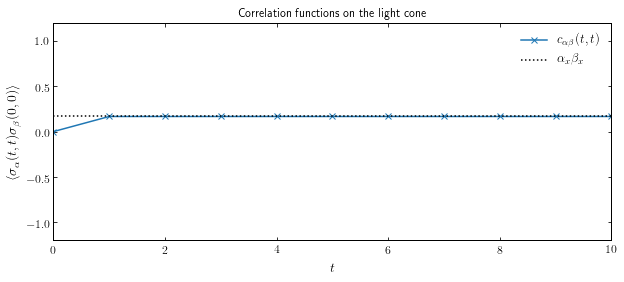

In [17]:
#Correlation functions on the light cone
fig, ax = plt.subplots(figsize=[10,4])

#Number of time steps
n_t = 15

q = U.shape[0]
op_t = op_b
corr_range = np.zeros(n_t,dtype=complex)
for n in range(n_t):
    corr_range[n] = np.einsum('ab,ba', op_a, op_t) / q
    op_t = M_channel_plus(op_t,U)
ax.plot(np.arange(n_t),corr_range.real,'x-',label=r'$c_{\alpha\beta}(t,t)$')
ax.plot(np.arange(n_t), [b_x*a_x]*n_t,'k:',label=r'$\alpha_x\beta_x$')

ax.set_title(r'Correlation functions on the light cone')        
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\langle \sigma_{\alpha}(t,t) \sigma_{\beta}(0,0) \rangle$')
ax.set_xlim([0.,10.])
ax.set_ylim([-1.2,1.2])
ax.legend()
plt.show()

## Kicked XY Model

In [18]:
#Kicked XY Model 
J = 0.1*np.pi
U = XY_gate(J = J)

#Check identities
print("Numerical check of presented identities (should all be zero)")
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd',U, np.conj(U), Id, Id)-np.einsum('ac,bd->abcd', Id, Id)))
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd',U, np.conj(U), X, X)-np.einsum('ac,bd->abcd', X, X)))
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd',U, np.conj(U), Id, Y)-np.einsum('ac,bd->abcd', Y, X)))
print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd',U, np.conj(U), X, Z)-np.einsum('ac,bd->abcd', Z, Id)))

print(np.linalg.norm(np.einsum('efab,ghcd,eg,fh->abcd',np.conj(U), U, Id, Id)-np.einsum('ac,bd->abcd', Id, Id)))
print(np.linalg.norm(np.einsum('efab,ghcd,eg,fh->abcd',np.conj(U), U, Z, Id)-np.einsum('ac,bd->abcd', X, Z)))
print(np.linalg.norm(np.einsum('efab,ghcd,eg,fh->abcd',np.conj(U), U, X, X)-np.einsum('ac,bd->abcd', X, X)))
print(np.linalg.norm(np.einsum('efab,ghcd,eg,fh->abcd',np.conj(U), U, Y, X)-np.einsum('ac,bd->abcd', Id, Y)))

print(np.linalg.norm(np.einsum('abef,cdgh,eg,fh->abcd',U, np.conj(U), X, Id)
      - np.sin(2.*J)*np.einsum('ac,bd->abcd',Id,X) - np.cos(2.*J)*np.einsum('ac,bd->abcd',Z,Y)))


Numerical check of presented identities (should all be zero)
0.0
0.0
4.1540741810552243e-16
4.1540741810552243e-16
3.925231146709438e-17
4.742874840267547e-16
3.925231146709438e-17
4.742874840267547e-16
4.4235108494242803e-16


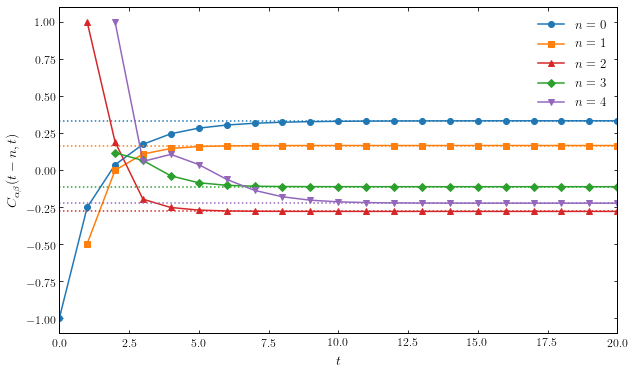

In [19]:
#Calculate OTOC given sigma_alpha and sigma_beta
a_x, a_y, a_z = np.sqrt(1./6.), np.sqrt(1./2.), np.sqrt(1./3.)
b_x, b_y, b_z =  np.sqrt(1./6.), -np.sqrt(1./2.), np.sqrt(1./3.)

#Construct sigma_alpha and sigma_beta
op_a, op_b = a_x*X+a_y*Y+a_z*Z, b_x*X+b_y*Y+b_z*Z

#Number of steps
n_t = 25

#Create figure
fix, ax = plt.subplots(figsize=[10,6])

#C(t,t)
[t_range, OTOC] = evol_even(U, op_a, op_b, 1, n_t)
ax.plot(t_range, OTOC.real,'C0o-',label=r'$n=0$')
ax.plot(t_range, [a_y**2+(2.*b_z**2-1.)*(1.-a_y**2)]*len(t_range),'C0:')

#C(t-1,t)
[t_range, OTOC] = evol_odd(U, op_a, op_b, 1, n_t)
ax.plot(t_range+1., OTOC.real,'C1s-',label=r'$n=1$')
ax.plot(t_range, [a_y**2+(2.*b_x**2-1.)*(1.-a_y**2)]*len(t_range),'C1:')

#C(t-2,t)
[t_range, OTOC] = evol_even(U, op_a, op_b, 2, n_t)
ax.plot(t_range+1., OTOC.real,'C3^-',label=r'$n=2$')
ax.plot(t_range, [2.*(b_x**2*a_x**2+b_y**2*a_z**2+b_z**2*a_y**2)-1.]*len(t_range),'C3:')

#C(t-3,t)
[t_range, OTOC] = evol_odd(U, op_a, op_b, 2, n_t)
ax.plot(t_range+2., OTOC.real,'C2D-',label=r'$n=3$')
ax.plot(t_range, [a_z**2+(2.*b_x**2-1.)*(1.-a_z**2)]*len(t_range),'C2:')

#C(t-4,t)
[t_range, OTOC] = evol_even(U, op_a, op_b, 3, n_t)
ax.plot(t_range+2., OTOC.real,'C4v-',label=r'$n=4$')
ax.plot(t_range, [2.*(b_x**2*a_x**2+b_y**2*a_y**2+b_z**2*a_z**2)-1.]*len(t_range),'C4:')

ax.set_xlim([0,20.])
ax.set_ylim([-1.1,1.1])
ax.set_ylabel(r'$C_{\alpha \beta}(t-n,t)$')
ax.set_xlabel(r'$t$')
ax.legend()
plt.show()

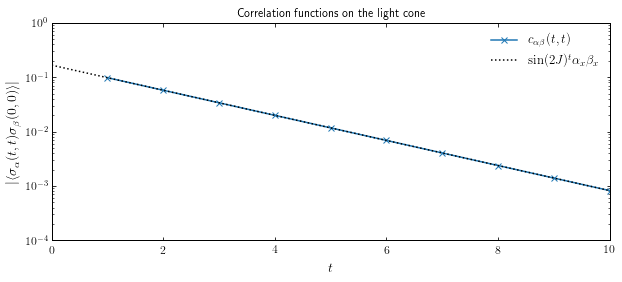

In [22]:
#Correlation functions on the light cone
fig, ax = plt.subplots(figsize=[10,4])

#Number of time steps
n_t = 20

q = U.shape[0]
corr_range = np.zeros(n_t,dtype=complex)
op_t = op_a
for n in range(n_t):
    corr_range[n] = np.einsum('ab,ba', op_b, op_t) / q
    op_t = M_channel_plus(op_t,U)
ax.semilogy(np.arange(1,n_t),np.abs(corr_range[1:]),'x-',label=r'$c_{\alpha\beta}(t,t)$')
ax.semilogy(np.arange(n_t),a_x*b_x*np.sin(2.*J)**np.arange(n_t),'k:',label=r'$\sin(2J)^{t} \alpha_x \beta_x $')

ax.set_title(r'Correlation functions on the light cone')        
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$|\langle \sigma_{\alpha}(t,t) \sigma_{\beta}(0,0) \rangle|$')
ax.set_xlim([0.,10.])
ax.set_ylim([1e-4,1.])
ax.legend()
plt.show()
